<a href="https://colab.research.google.com/github/brrikcy/deep-learning/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:
try:
 tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # Get TPU resolver
 print('Running on TPU ', tpu.master())
except ValueError:
 print('TPU not found.')
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# Define TPU
strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  


In [ ]:
# 1. Load Data (GoogleStock Prices)
stock_data = yf.download('GOOG', start='2019-01-01', end='2024-01-01')
stock_data = stock_data[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 2. Preprocess the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [ ]:
# Function to create sequences (X, y) for GRU input
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [ ]:
# Create sequences for train and test sets
time_steps = 60
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape X_train and X_test to be in the format [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# 3. Build the GRU Model (Stacked GRU with 2 layers)
model = Sequential()

# Add the first GRU layer
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Add a second GRU layer (with return_sequences=False)
model.add(GRU(units=50, return_sequences=False))

# Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Dense layer to output the final prediction
model.add(Dense(units=1))

# 4. Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# 5. Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 6. Make Predictions
predictions = model.predict(X_test)

Epoch 1/20
30/30 [==============================] - 5s 64ms/step - loss: 0.0425 - val_loss: 0.0119
Epoch 2/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 3/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0033 - val_loss: 9.2797e-04
Epoch 4/20
30/30 [==============================] - 1s 41ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 5/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 6/20
30/30 [==============================] - 1s 42ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 7/20
30/30 [==============================] - 1s 37ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 8/20
30/30 [==============================] - 1s 43ms/step - loss: 0.0027 - val_loss: 9.5758e-04
Epoch 9/20
30/30 [==============================] - 1s 36ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/20
30/30 [==============================] - 1s 39ms/step - loss: 0.0025 - val_loss: 6.9479e-

In [ ]:
# Inverse transform the predictions and actual values to original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

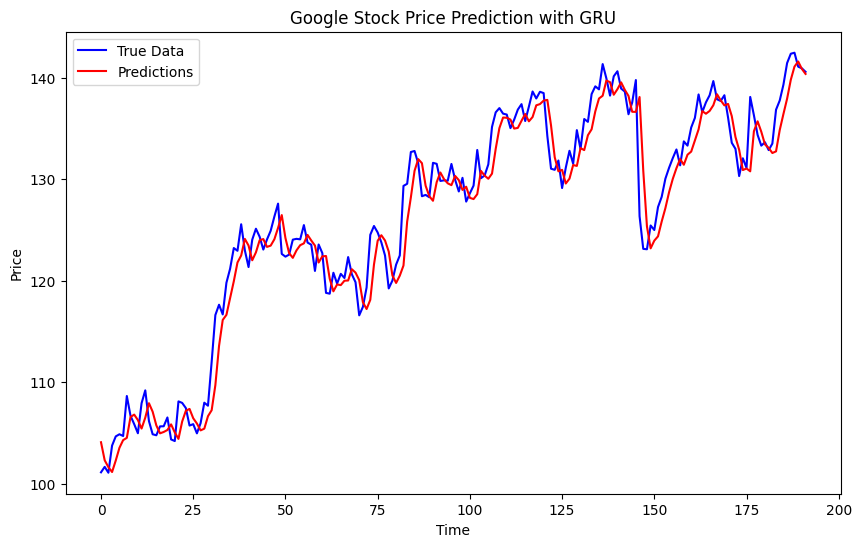

In [ ]:
# 7. Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='True Data', color='blue')
plt.plot(predictions_rescaled, label='Predictions', color='red')
plt.title('Google Stock Price Prediction with GRU')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Optionally, evaluate the model using RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f'RMSE: {rmse}')

RMSE: 2.474700588973521
